In [69]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score

In [70]:
df = pd.read_csv('AB_NYC_2019.csv')
print(f"Données chargées : {df.shape}")

Données chargées : (48895, 16)


In [71]:
# Supprimer les prix aberrants et les valeurs manquantes
df_clean = df.copy()
df_clean = df_clean[(df_clean['price'] > 0) & (df_clean['price'] < 1000)]
df_clean = df_clean.dropna(subset=['price', 'neighbourhood_group', 'room_type'])
df_clean['reviews_per_month'].fillna(0, inplace=True)

print(f"Après nettoyage : {df_clean.shape}")

Après nettoyage : (48586, 16)


In [72]:
features = [
    'neighbourhood_group',
    'room_type', 
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'availability_365'
]

X = df_clean[features].copy()
y = df_clean['price'].copy()

In [73]:
encoders = {}
for col in ['neighbourhood_group', 'room_type']:
    encoder = LabelEncoder()
    X[col] = encoder.fit_transform(X[col])
    encoders[col] = encoder

print("Features encodées")

Features encodées


In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (38868, 7), Test: (9718, 7)


In [75]:
model = GradientBoostingRegressor(
    n_estimators=100,    # Nombre d'arbres
    max_depth=5,         # Profondeur des arbres
    learning_rate=0.1,   # Vitesse d'apprentissage
    random_state=42
)

model.fit(X_train, y_train)
print("Modèle entraîné !")

Modèle entraîné !


In [76]:
# Prédictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Métriques
print("\n=== RÉSULTATS ===")
print(f"Train R² : {r2_score(y_train, y_pred_train):.3f}")
print(f"Test R²  : {r2_score(y_test, y_pred_test):.3f}")
print(f"Test MAE : ${mean_absolute_error(y_test, y_pred_test):.2f}")


=== RÉSULTATS ===
Train R² : 0.496
Test R²  : 0.445
Test MAE : $48.36


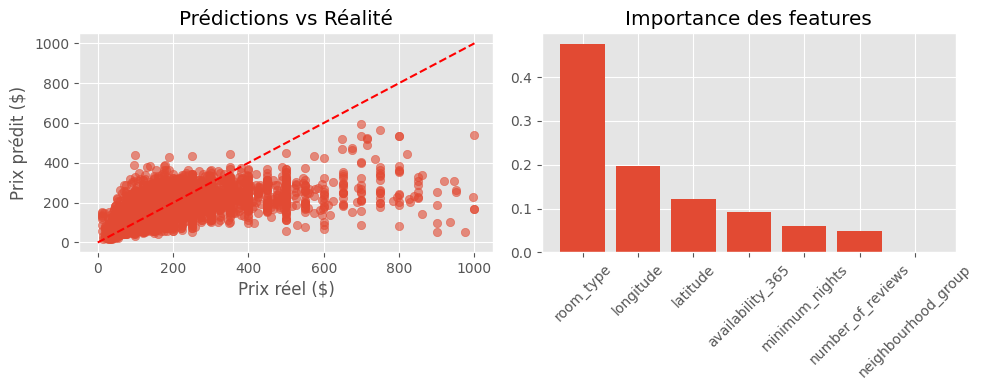

In [77]:
plt.figure(figsize=(10, 4))

# Prédictions vs vraies valeurs
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([0, 1000], [0, 1000], 'r--')
plt.xlabel('Prix réel ($)')
plt.ylabel('Prix prédit ($)')
plt.title('Prédictions vs Réalité')

# Importance des features
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.subplot(1, 2, 2)
plt.bar(range(len(features)), feature_importance['importance'])
plt.xticks(range(len(features)), feature_importance['feature'], rotation=45)
plt.title('Importance des features')
plt.tight_layout()
plt.show()

In [78]:
model_data = {
    'model': model,
    'encoders': encoders,
    'features': features
}

with open('airbnb_simple_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("Modèle sauvegardé dans 'airbnb_simple_model.pkl'")

Modèle sauvegardé dans 'airbnb_simple_model.pkl'


In [79]:
def predict_price(data):
    """Prédire le prix d'un logement"""
    df_input = pd.DataFrame([data])
    
    # Encoder les variables catégorielles
    for col in ['neighbourhood_group', 'room_type']:
        df_input[col] = encoders[col].transform(df_input[col])
    
    # Prédire
    price = model.predict(df_input[features])[0]
    return round(price, 2)

In [80]:
example = {
    'neighbourhood_group': 'Manhattan',
    'room_type': 'Entire home/apt',
    'latitude': 40.7589,
    'longitude': -73.9851,
    'minimum_nights': 2,
    'number_of_reviews': 10,
    'availability_365': 365
}

predicted_price = predict_price(example)
print(f"\n💲 Prix prédit pour l'exemple : ${predicted_price}")


💲 Prix prédit pour l'exemple : $334.45


In [81]:
print("\n=== RÉSUMÉ DU MODÈLE SIMPLE ===")
print(f"✅ Modèle : Gradient Boosting")
print(f"✅ Features utilisées : {len(features)}")
print(f"✅ Performance (R²) : {r2_score(y_test, y_pred_test):.3f}")
print(f"✅ Erreur moyenne : ${mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"✅ Temps d'exécution : Rapide !")


=== RÉSUMÉ DU MODÈLE SIMPLE ===
✅ Modèle : Gradient Boosting
✅ Features utilisées : 7
✅ Performance (R²) : 0.445
✅ Erreur moyenne : $48.36
✅ Temps d'exécution : Rapide !
